# Run generateSTLs.py

In [ ]:
%run -i 'generateSTLs.py'

Total of 334 DICOM images.
First 5 filenames:
Elapsed time: 1.5409579277038574 sec.
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 254
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.2.1125.1.66536223425751815542154488572927746
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.2.1143.107.104.103.115.3.0.5.111.124.113
(0002, 0013) Implementation Version Name         SH: 'GDCM 3.0.5'
(0002, 0016) Source Application Entity Title     AE: 'GDCM/ITK 5.1.2'
-------------------------------------------------
(0018, 0050) Slice Thickness                     DS: '1.0'
(0020, 0013) Instance Number                     IS: '1'
(0020, 0032) Image Position (Patient)            DS: [8.63811

100%|██████████| 5/5 [00:00<00:00, 230.68it/s]


Elapsed time: 0.4115927219390869 sec.
Slice Thickness: 1.000000
Pixel Spacing (row, col): (0.939453, 0.939453) 
Each image is (84.55078125mm x 143.736328125mm)
Bone length 334.0mm
Shape before resampling	 (334, 90, 153)
Elapsed time: 1.819244384765625 sec.
Shape after resampling	 (334, 85, 144)
Each image is (84.55078125mm x 143.736328125mm)
Elapsed time: 0.43967747688293457 sec.


100%|██████████| 5/5 [00:00<00:00, 197.47it/s]


Elapsed time: 0.26821351051330566 sec.


100%|██████████| 5/5 [00:00<00:00, 230.60it/s]


Elapsed time: 0.2516043186187744 sec.


100%|██████████| 5/5 [00:00<00:00, 232.18it/s]


Elapsed time: 0.24702954292297363 sec.


### This is the code of the generateSTLS.py script against a single TAC:

In [1]:
import json
import vtk
import numpy as np
from vtk.util import numpy_support
from vtk.util.numpy_support import vtk_to_numpy
import matplotlib.pyplot as plt
from tqdm import tqdm
from os import listdir
from os.path import isfile, join
import logging
from logging import FileHandler
from vlogging import VisualRecord
import cv2
import math
from scipy.ndimage import rotate
import os
# import vg

import sys
sys.path.append("../libs")
from libraries import load_scan, get_pixels_hu, sample_stack, resample, find_bounding_box, find_bounding_box_sample_stack, make_bonesmask, CreateTissueFromArray, CreateTissueMap, CreateLut, compute_thickness_image, convertTo1D, show_cuts, show_cuts_position, rotation_matrix_from_vectors, orientation_slice, getOrientationMainVector, drawAxis, getClosestPointInRadius, color3DModelWithThickness, getArea, show_cuts_position_restored, WriteImage

import configparser


####################
# READ CONFIG FILE #
####################

# instantiate
config = configparser.RawConfigParser()

# parse existing file
config.read('../config/file.ini')

# read values from a section
output_path = config.get('dicom', 'output_path')
if not os.path.exists(output_path+"stl"):
    os.makedirs(output_path+"stl")
resources_path = config.get('dicom', 'resources_path')
data_path_dicom = config.get('dicom', 'data_path_dicom')

# read values from a section
spacing = config.get('pre-process', 'spacing')
spacing = json.loads(spacing)
threshold = config.getint('pre-process', 'threshold')
extract = config.get('pre-process', 'extract')
extract = json.loads(extract)
size = config.getint('pre-process', 'size')
kernel_preErosion = config.get('pre-process', 'kernel_preErosion')
kernel_preErosion = json.loads(kernel_preErosion)
kernel_firstDilation = config.get('pre-process', 'kernel_firstDilation')
kernel_firstDilation = json.loads(kernel_firstDilation)
kernel_firstErosion = config.get('pre-process', 'kernel_firstErosion')
kernel_firstErosion = json.loads(kernel_firstErosion)

# read values from a section
threshold_between_min = config.getint('post-process', 'threshold_between_min')
threshold_between_max = config.getint('post-process', 'threshold_between_max')
convert_stl = config.getboolean('post-process', 'convert_stl')

ERRORES DETECTADOS:

* RJ1IJ08RNGMAL_14402192792119500 --> falla el algoritmo de detectar la bounding box. El tac parece que tiene objetos más brillantes que afectan. Hay que intentar recortar mejor la tibia
* RJ1LF1MD2MNC3_15735065101121600 --> falla el algoritmo de detectar la bounding box. Motivo??

In [2]:
foldername = "RJ1LF1MD2MNC3_15735065101121600"

In [3]:
# List ALL DICOM TACs
data_path_dicom = data_path_dicom
i = foldername

# Control of number of bones
id=0
    
# Increase the value to identify the bone
id+=1

# Path of slices
data_path = data_path_dicom+i
print(data_path)

/home/sanchezmel/arcus/project/validas/RJ1LF1MD2MNC3_15735065101121600


In [4]:
onlyfiles = [f for f in listdir(data_path) if isfile(join(data_path, f))]
print(onlyfiles[:5])

['1.3.6.1.4.1.11129.5.1.130278411853708519707609413364618264927.dcm', '1.3.6.1.4.1.11129.5.1.328806333177268961922461157774118190047.dcm', '1.3.6.1.4.1.11129.5.1.237325395985004888717094654419497132967.dcm', '1.3.6.1.4.1.11129.5.1.246710752761021352271340090002613842463.dcm', '1.3.6.1.4.1.11129.5.1.106010623300664869418350037535445377648.dcm']


Elapsed time: 1.8571250438690186 sec.
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 188
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.11129.5.1.182793042983406658108358105078207396391
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.3
(0002, 0013) Implementation Version Name         SH: 'dcm4che-null'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.11129.5.1.182793042983406658108358105078207396391
(0008, 0020) Study Date                          DA: 

100%|██████████| 5/5 [00:00<00:00, 144.67it/s]


Elapsed time: 0.29439401626586914 sec.


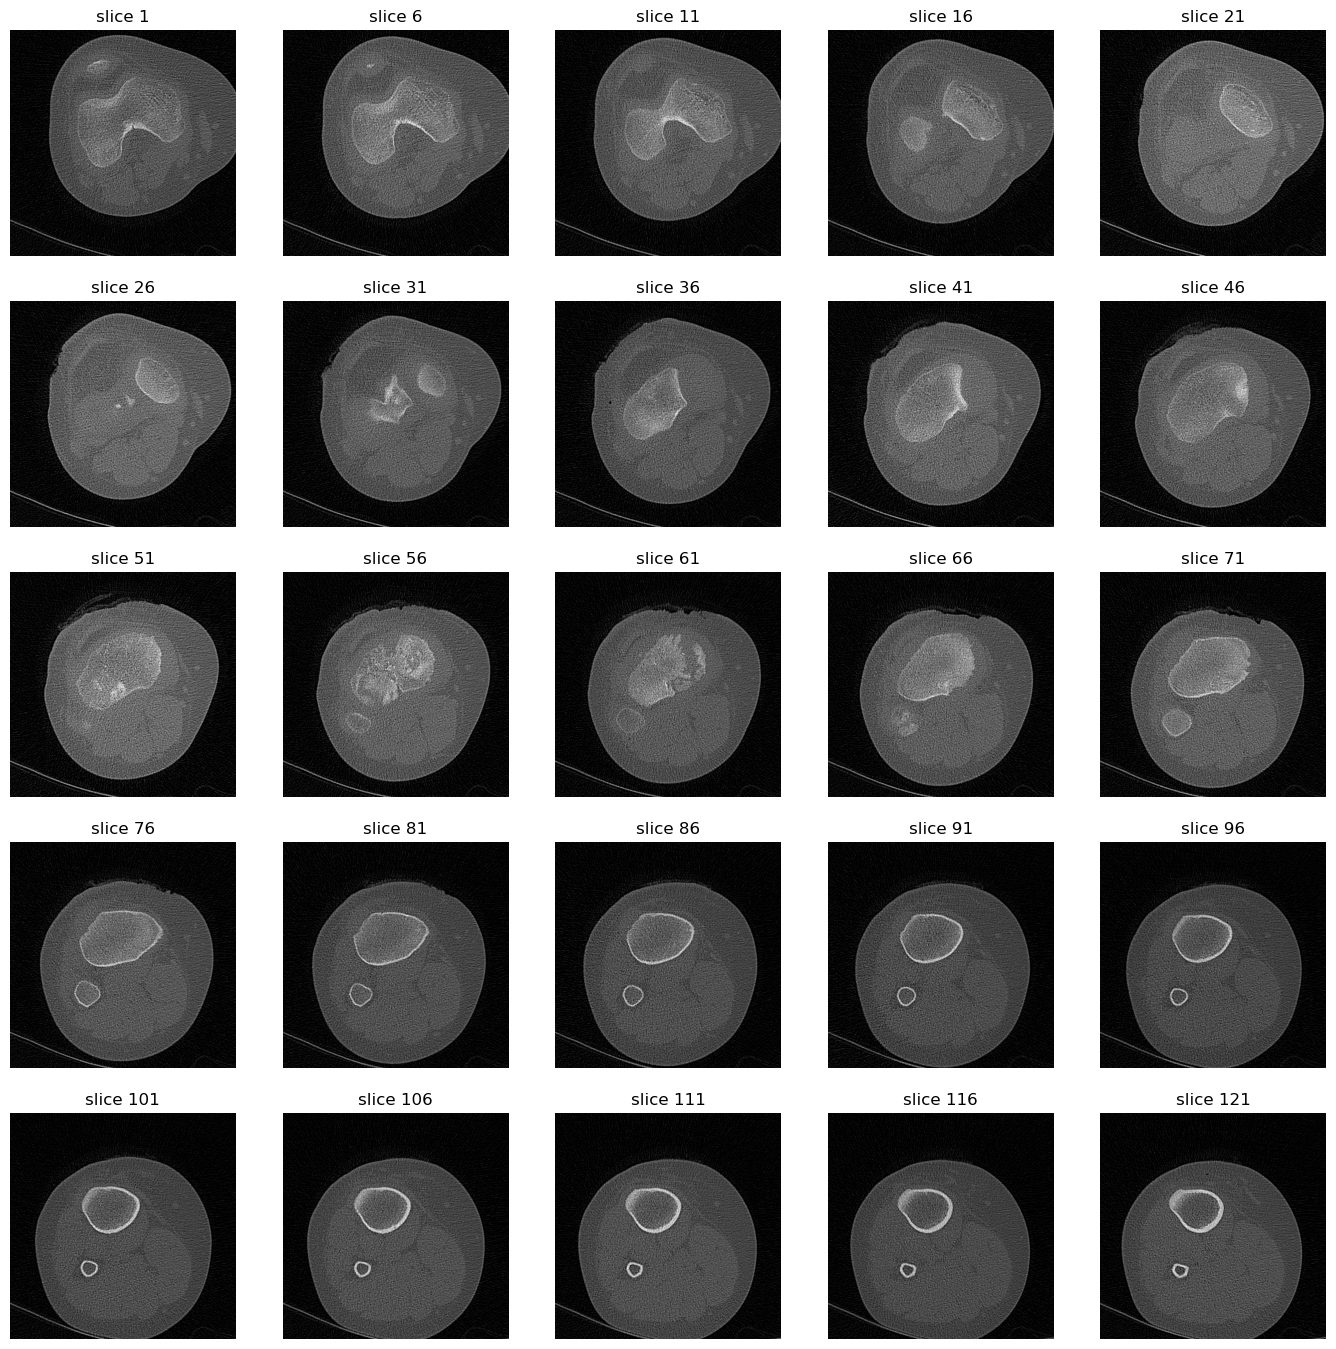

In [5]:
# Load all DICOM from a folder into a list for manipulation
slices=load_scan(data_path,onlyfiles)

# Show metadata
print(slices[0])

# Create a numpy matrix of Hounsfield Units (HU)
imgs = get_pixels_hu(slices)
    
# Load images
imgs_to_process = imgs

# Show & log imgs_to_process
sample_stack(imgs_to_process, rows=5, cols=5, start_with=1, show_every=5)
plt.savefig(resources_path+"Sample_stack.png")
cv_sample_stack = cv2.imread(resources_path+"Sample_stack.png")
resized = cv2.resize(cv_sample_stack, (1020,1020), interpolation = cv2.INTER_AREA)

Slice Thickness: 0.600000
Pixel Spacing (row, col): (0.283203, 0.283203) 
Each image is (145.0mm x 145.0mm)
Bone length 346.2000000000131mm
Shape before resampling	 (577, 512, 512)
Elapsed time: 14.662412405014038 sec.
Shape after resampling	 (346, 145, 145)
Each image is (145.0mm x 145.0mm)


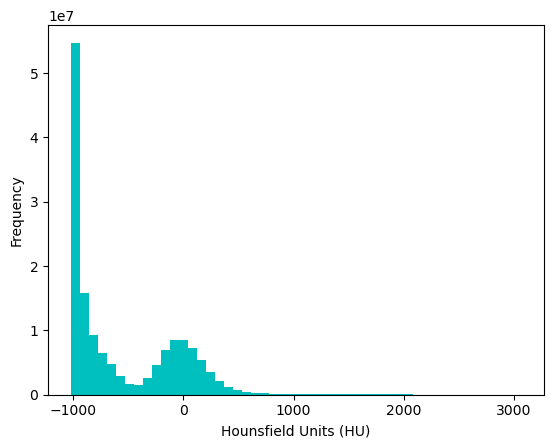

In [6]:
# Plot & log histogram to see Hounsfield Units (HU)
plt.figure()
plt.hist(imgs_to_process.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
#plt.show()
plt.savefig(resources_path+'Histogram.png')
cv_histogram = cv2.imread(resources_path+'Histogram.png')

# Print Slice Thickness & Pixel Spacing
print ("Slice Thickness: %f" % slices[0].SliceThickness)
print ("Pixel Spacing (row, col): (%f, %f) " % (slices[0].PixelSpacing[0], slices[0].PixelSpacing[1]))

# Print dimensions of one image & bone length
x,y=imgs_to_process[0].shape
print("Each image is ({}mm x {}mm)".format(x*slices[0].PixelSpacing[0],y*slices[0].PixelSpacing[1]))
print("Bone length {}mm".format(imgs_to_process.shape[0]*slices[0].SliceThickness))

# Print shape before resampling
print("Shape before resampling\t", imgs_to_process.shape)

# Resample
imgs_after_resamp, spacing = resample(imgs_to_process, slices, spacing)

# Print shape after resamplings
print("Shape after resampling\t", imgs_after_resamp.shape)

# Print dimensions of one image after resampling
x,y=imgs_after_resamp[0].shape
print("Each image is ({}mm x {}mm)".format(x*spacing[1],y*spacing[2]))

Elapsed time: 0.4288642406463623 sec.


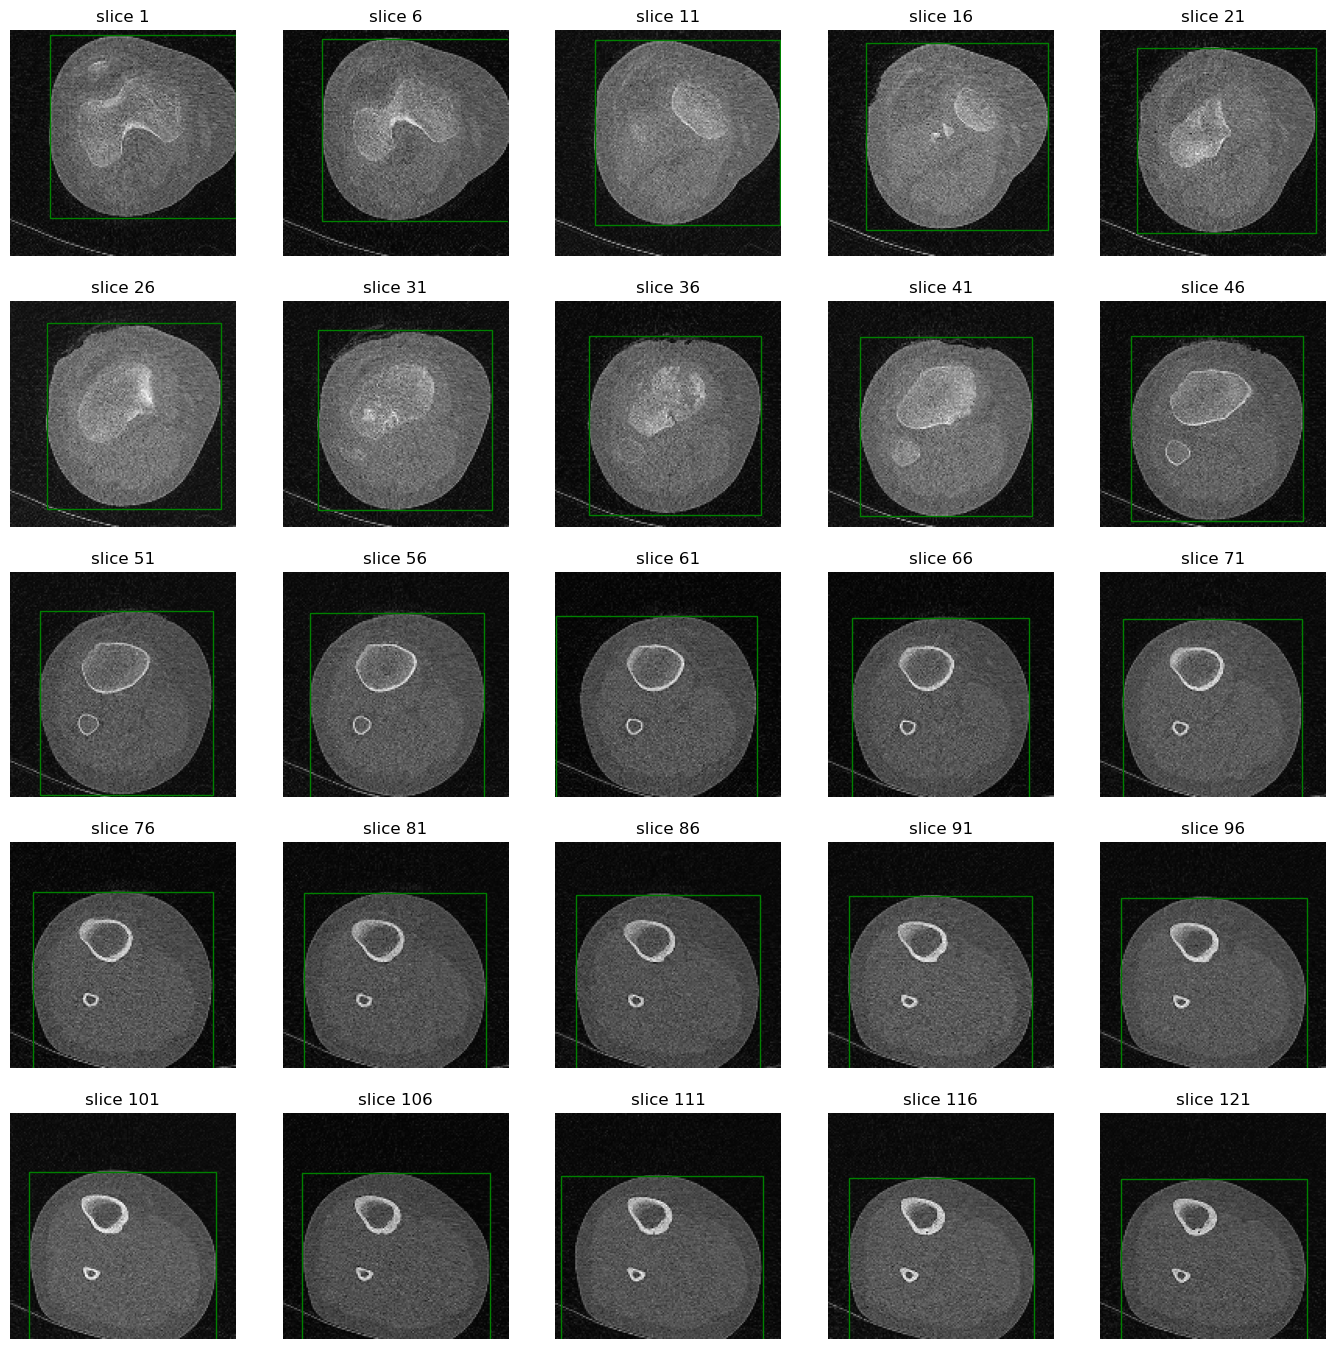

In [7]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

# (x,y),(X,Y),W,H=find_bounding_box(img, hu=True,threshold=50, display=True, sizex=8, sizey=8, linewidth=2,title=False)
# Show bounding box detection of images
f=find_bounding_box_sample_stack(imgs_after_resamp, hu=True, show_box=True, threshold=50, rows=5, cols=5, start_with=1, show_every=5)

Si no obtenemos buenos resultados en la bounding box, analizar el código siguiente para ver si el threshold está bien elegido

In [8]:
def find_bounding_box(img, hu=True,threshold=200, display=True, sizex=5, sizey=5, title=True, linewidth=1):
    if hu==False:
        #then RGB
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        #if HU image
        im_normalized=(img - img.min()) / (img.max() - img.min())
        im_normalized_scaled=(im_normalized*255)
        gray = np.array(im_normalized_scaled, dtype=np.uint8)
    thresh = cv2.inRange(gray, threshold, 255)
    # find contour
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # get rectangle
    if len(contours)==0:
        return (0,0),(0,0),0, 0
    else:  
        # Elijo el contorno más grande
        area=0
        for c in range(len(contours)):
            x,y,w,h = cv2.boundingRect(contours[c])

            if w*h>=area:
                area=w*h
                x_def=x
                y_def=y
                w_def=w
                h_def=h
                index=c
        middle = img[y_def:y_def+h_def,x_def:x_def+w_def]
    
    if display:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Tres imágenes: original, thresh y contornos

        # Imagen original
        if len(img.shape) == 2:  # Escala de grises
            axs[0].imshow(img, cmap="gray")
        else:  # RGB o BGR
            axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[0].set_title("Imagen original")
        axs[0].axis("off")

        # Imagen de umbral
        axs[1].imshow(thresh, cmap='gray')
        axs[1].set_title("Imagen umbral (thresh)")
        axs[1].axis("off")

        # Imagen con contornos
        img_with_contours = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)  # Para dibujar contornos
        cv2.drawContours(img_with_contours, contours, -1, (0, 255, 0), 2)  # Dibuja contornos en verde
        axs[2].imshow(cv2.cvtColor(img_with_contours, cv2.COLOR_BGR2RGB))
        axs[2].set_title("Contornos detectados")
        axs[2].axis("off")

        # Ajustar layout y mostrar
        plt.tight_layout()
        plt.show()
    
    return (x_def,y_def),(x_def+w_def,y_def+h_def),w_def, h_def

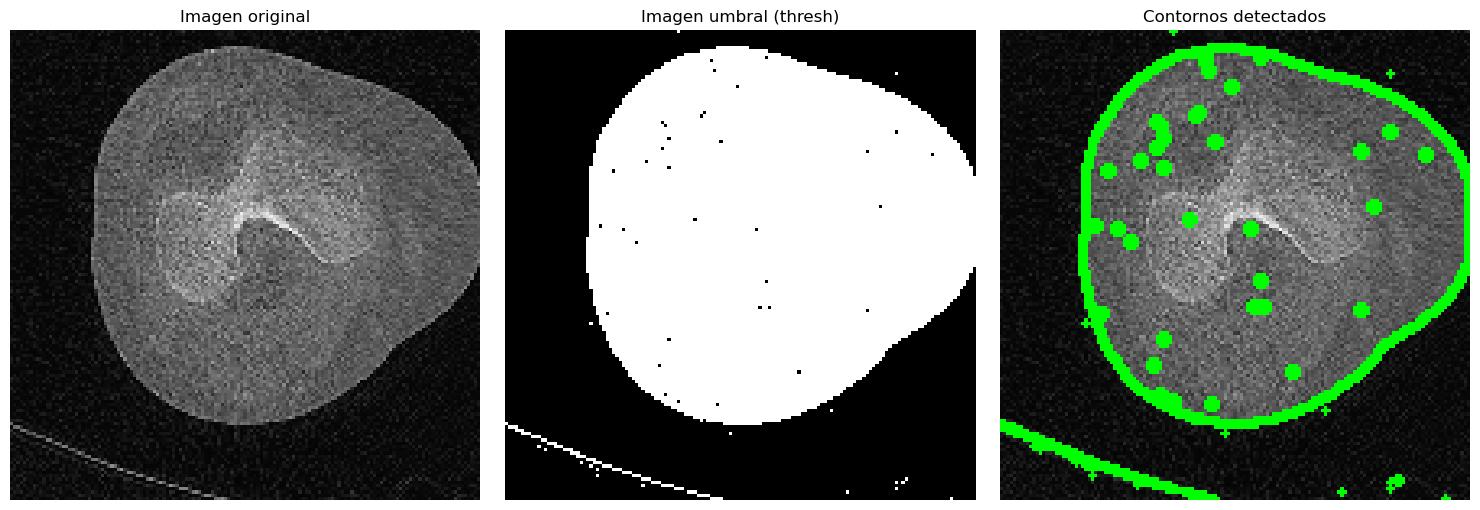

In [98]:
(x,y),(x2,y2),w, h = find_bounding_box(imgs_after_resamp[6,:,:], hu=True,threshold=50, display=True, sizex=5, sizey=5, title=True, linewidth=1)

In [9]:
# Calculate size for the spacing used. Reference 0.5 --> size=30
auto_size = int(0.5*30/spacing[1])
if size <= auto_size-5 or size >= auto_size+5:
    size=auto_size

# Arrays in which the results of make_bonesmask function will be stored
masked_bones= []
masked_bones_hu= []
masks =[]
labels =[]
    
# Obtain masked bones, masks and labels of the masks
counter=0
for img in tqdm(imgs_after_resamp):
    mascara,imagen_norm,imagen_hu,etiquetas=make_bonesmask(img, kernel_preErosion, kernel_firstDilation, kernel_firstErosion, hu=True, threshold=threshold, display=False, extract=extract, size=size)
    masked_bones.append(imagen_norm)
    masked_bones_hu.append(imagen_hu)
    masks.append(mascara)
    labels.append(etiquetas)


100%|██████████| 346/346 [02:59<00:00,  1.93it/s]


100%|██████████| 5/5 [00:00<00:00, 27.65it/s]


Elapsed time: 0.4186723232269287 sec.


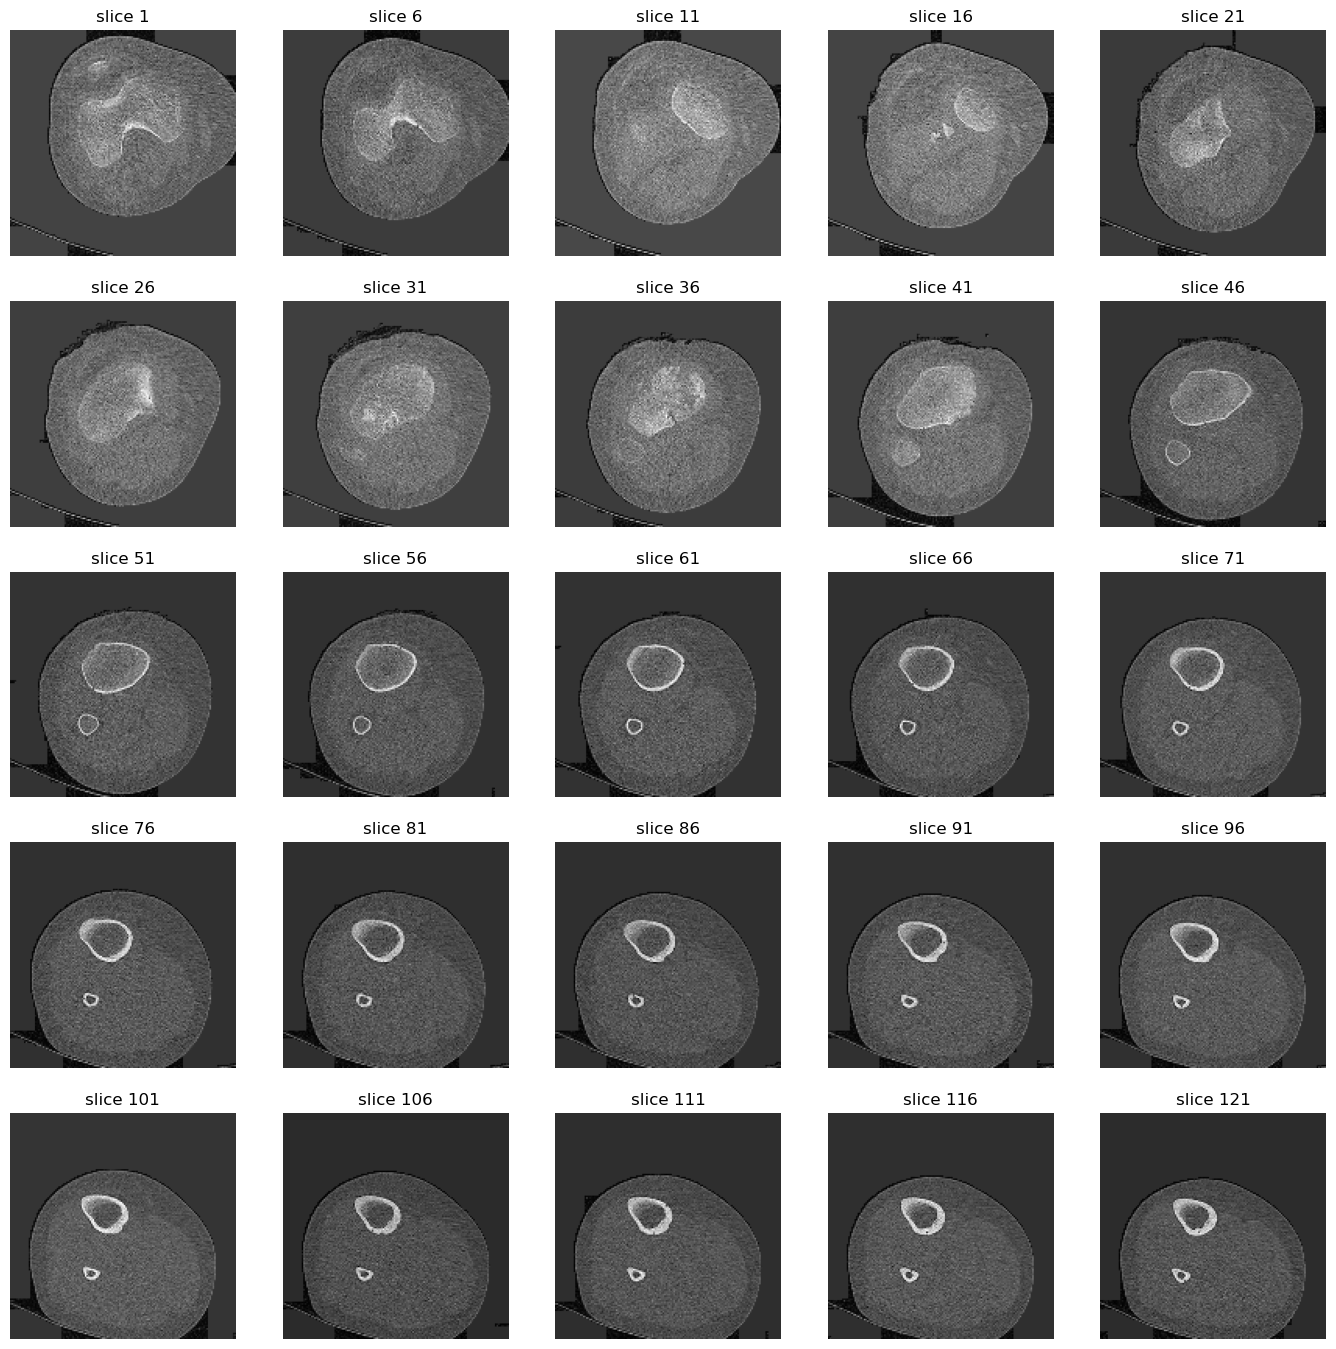

In [10]:
# Show & log masked bones
sample_stack(masked_bones, rows=5, cols=5, start_with=1, show_every=5)

100%|██████████| 5/5 [00:00<00:00, 217.99it/s]


Elapsed time: 0.27426862716674805 sec.


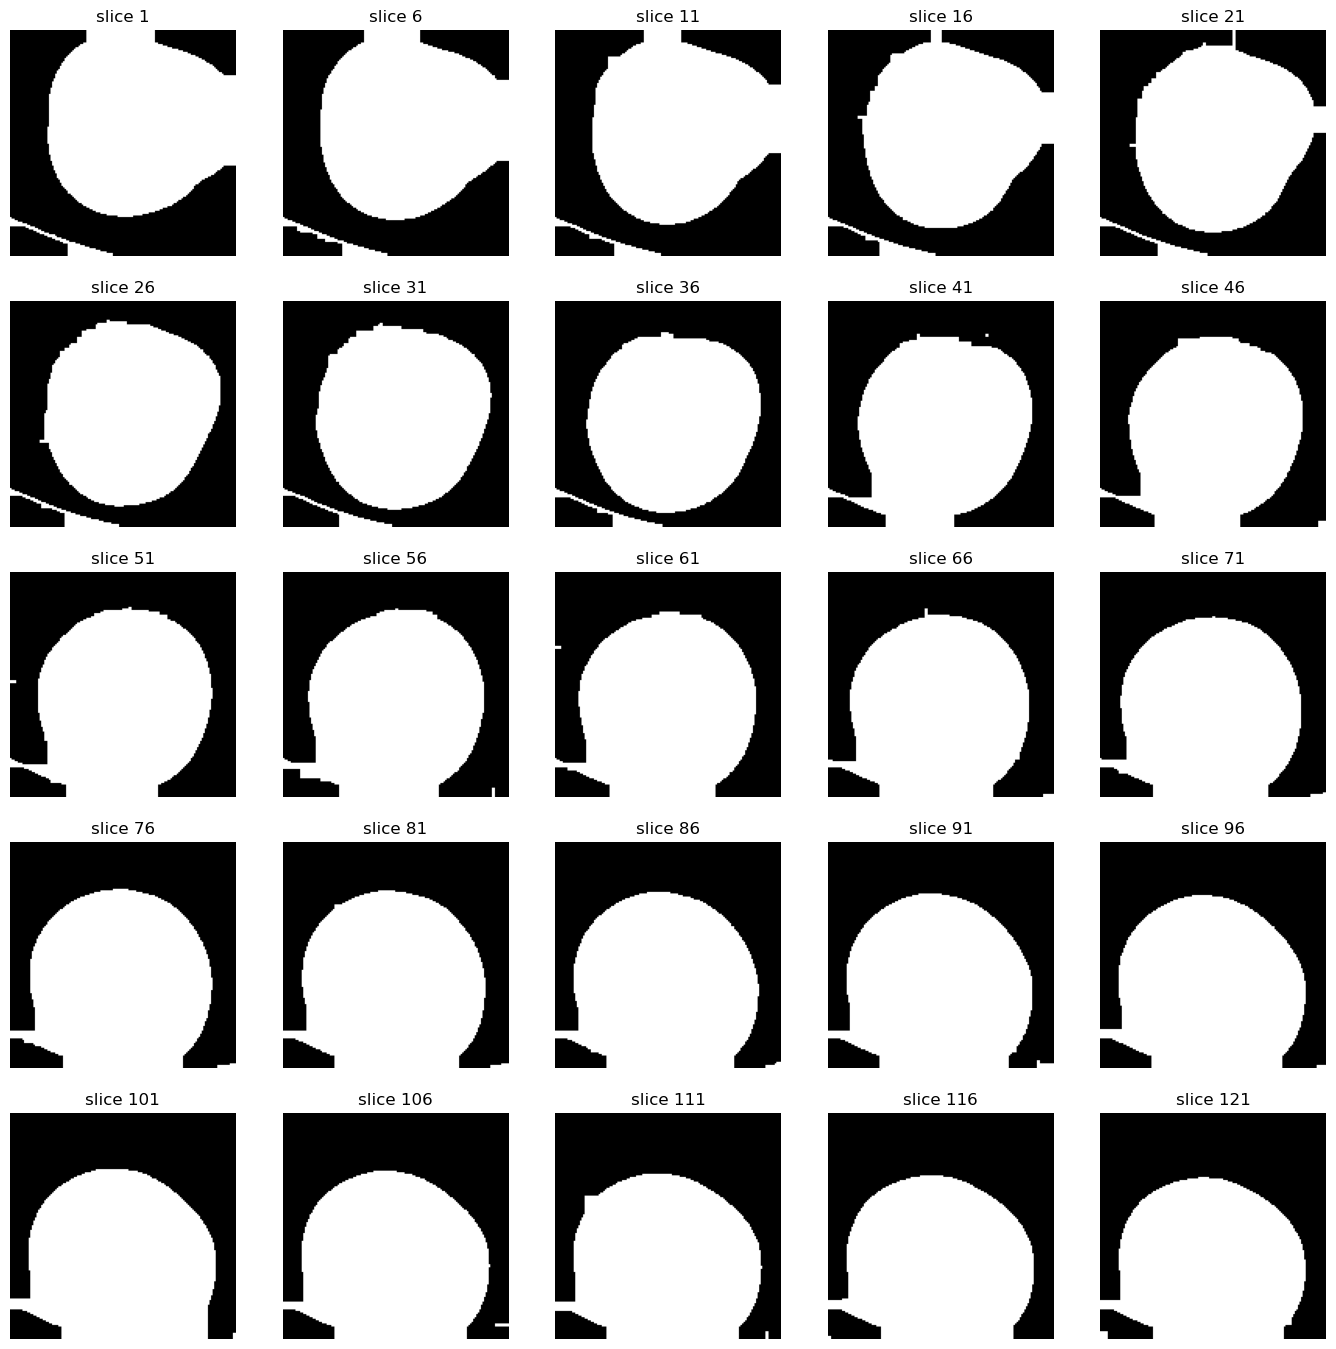

In [11]:
# Show & log masks
sample_stack(masks, rows=5, cols=5, start_with=1, show_every=5)

100%|██████████| 5/5 [00:00<00:00, 224.70it/s]


Elapsed time: 0.26030421257019043 sec.


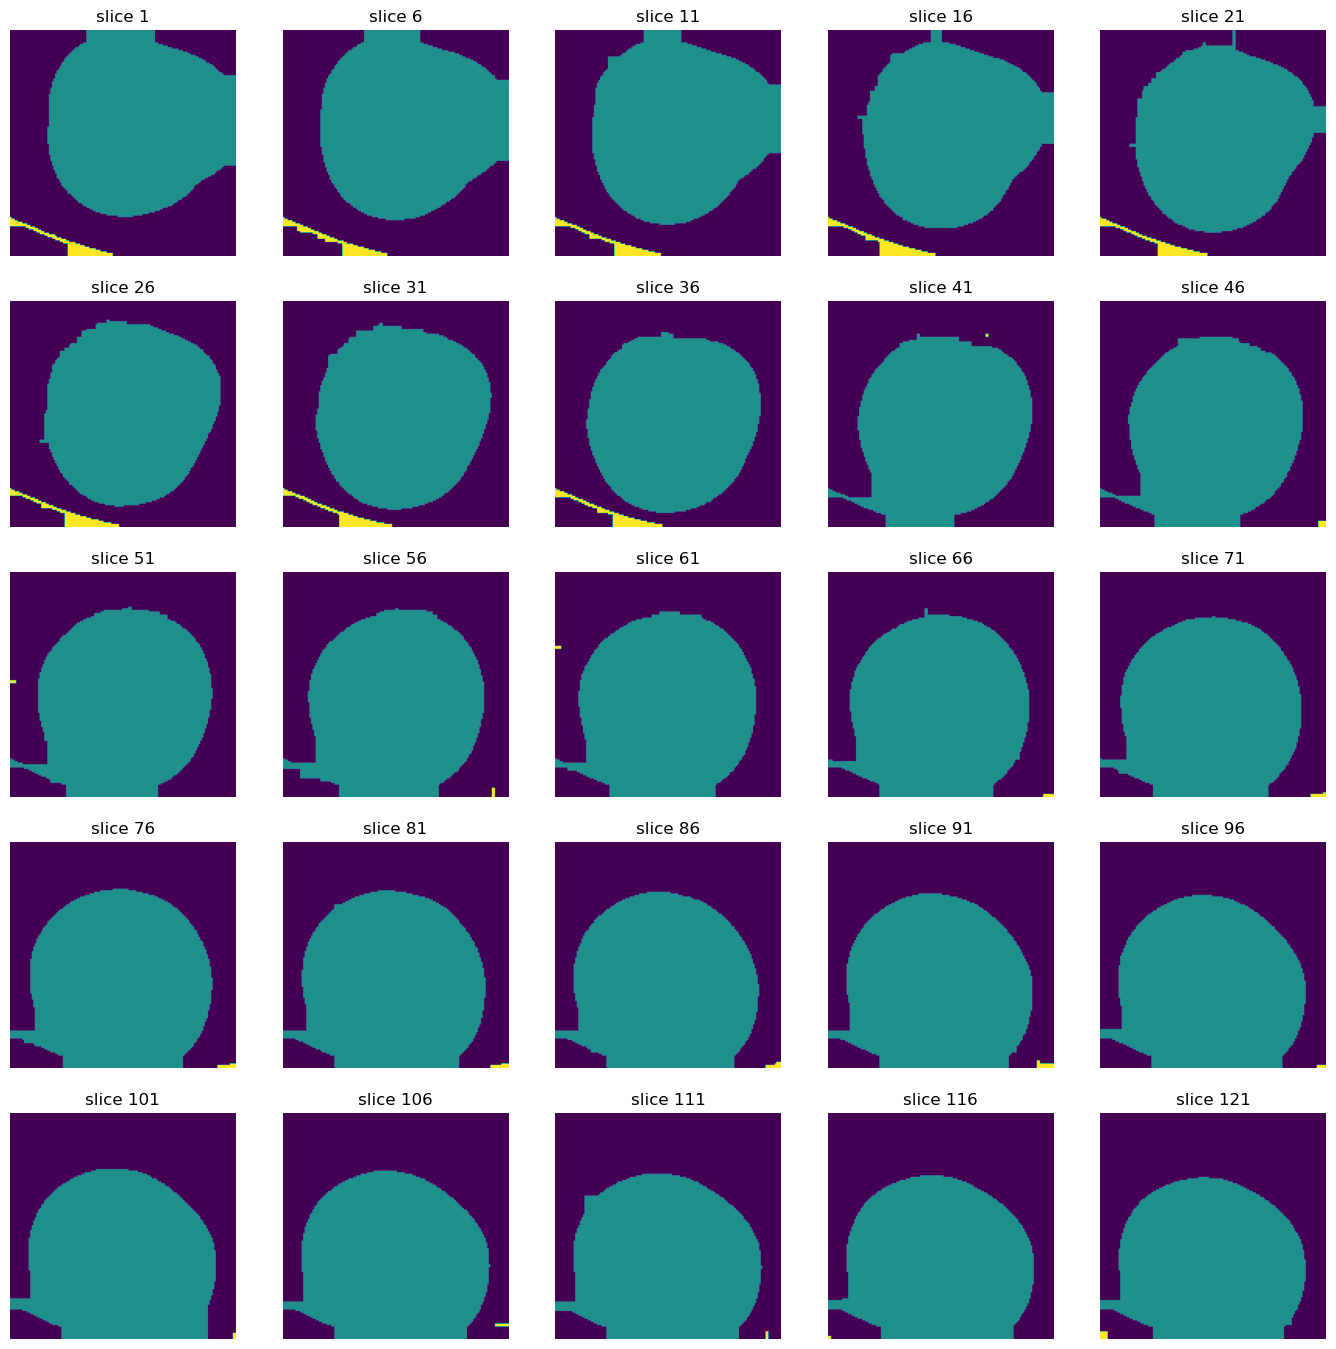

In [12]:
# Show & log labels of the mask
sample_stack(labels, rows=5, cols=5, start_with=1, show_every=5, color=True)

Esta parte no funciona en jpuyter porque no consigo que ejecute vtk con los interactors:

In [13]:
# !pip install ipyvtklink

In [ ]:
# Convert images into a numpy array
imgs_after_mask=np.array(masked_bones_hu)
   
# Load file and obtain the shape
imgs_to_process = imgs_after_mask.astype(np.float64) 
imgs = imgs_to_process
data_shape = imgs.shape
print(data_shape)

# Create vtk model and set dimensions,spacing and origin for the 3D visualization
imdata = vtk.vtkImageData()
depthArray = numpy_support.numpy_to_vtk(num_array=imgs.ravel(), deep=True, array_type=vtk.VTK_FLOAT)
imdata.SetDimensions((data_shape[2], data_shape[1], data_shape[0])) 
imdata.SetSpacing([spacing[2], spacing[1], spacing[0]])
imdata.SetOrigin([0,0,0])
_=imdata.GetPointData().SetScalars(depthArray)

selectTissue = vtk.vtkImageThreshold()
selectTissue.ThresholdBetween(threshold_between_min,threshold_between_max) # Select which HU represent
selectTissue.ReplaceInOn()    # Determines whether to replace the pixel in range with InValue
selectTissue.SetInValue(255)  # set all values between ThrIn,ThrOut to 255
selectTissue.ReplaceOutOn()
selectTissue.SetOutValue(0)   # set all values otside ThrIn,ThrOut to 0
selectTissue.SetInputData(imdata)
selectTissue.Update()

#Apply a gaussian filter to smooth the 3D
gaussianRadius = 5
gaussianStandardDeviation = 1.0
gaussian = vtk.vtkImageGaussianSmooth()
gaussian.SetStandardDeviations(gaussianStandardDeviation, gaussianStandardDeviation, gaussianStandardDeviation)
gaussian.SetRadiusFactors(gaussianRadius, gaussianRadius, gaussianRadius)
gaussian.SetInputData(selectTissue.GetOutput())
gaussian.Update()
    
# Create a surface
surface = vtk.vtkMarchingCubes()
surface.SetInputData(gaussian.GetOutput())
surface.ComputeNormalsOn()
surface.SetValue(0, 127.5)  # define surface 0 as a isosurface at HU level 127.5

# Create a renderer and apply backgtound color
renderer = vtk.vtkRenderer()
colors = vtk.vtkNamedColors()
renderer.SetBackground(colors.GetColor3d('DarkSlateGray'))

# Create the render window
render_window = vtk.vtkRenderWindow()
render_window.AddRenderer(renderer)
render_window.SetWindowName('MarchingCubes')

# Create an interactor
interactor = vtk.vtkRenderWindowInteractor()
interactor.SetRenderWindow(render_window)

# Create a mapper
mapper = vtk.vtkPolyDataMapper()
mapper.SetInputConnection(surface.GetOutputPort())
mapper.ScalarVisibilityOff()

# Create an actor
actor = vtk.vtkActor()
actor.SetMapper(mapper)
actor.GetProperty().SetColor(colors.GetColor3d('MistyRose'))

# Apply the actor to the renderer
renderer.AddActor(actor)
renderer.ResetCamera()
renderer.ResetCameraClippingRange()
camera = renderer.GetActiveCamera()
camera.Elevation(45)
camera.Azimuth(90)
camera.Roll(-45)
renderer.SetActiveCamera(camera)

# Show the 3D model
render_window.Render()
# Capture the rendered scene to an image
window_to_image_filter = vtk.vtkWindowToImageFilter()
window_to_image_filter.SetInput(render_window)
window_to_image_filter.Update()

interactor.Start()